In [102]:
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install rasterio
!{sys.executable} -m pip install rioxarray



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 567.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.2 MB/s eta 0:00:00a 0:00:01


In [4]:
import geopandas as gpd
import pandas as pd

import rasterio
from rasterio.plot import show as rasterio_show
import matplotlib.pyplot as plt
from rasterio.mask import mask
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
from rasterio.warp import reproject, Resampling
from rasterio.enums import Resampling
from pyproj import Proj, transform
from rasterio.transform import from_origin

# Load shapefile
shp_file = '../Maps_QGIS/gadm36_IND_shp/gadm36_IND_0.shp'
gdf = gpd.read_file(shp_file)


# Load TIFF file
tiff_file = '../Data/Global Anemia Prevalence Geospatial Estimates 2000-2019/3 - All Anemia [GeoTIFF]/Mean/IHME_GLOBAL_ANEMIA_2000_2019_ALL_ANEMIA_PREV_MEAN_2019_Y2020M08D31.TIF'
tiff_reprojected = '../Data/Global Anemia Prevalence Geospatial Estimates 2000-2019/5 - Severe Anemia [GeoTIFF]/Mean/reprojected.tif'

# Open the raster file
with rasterio.open(tiff_file, 'r') as src:
    # Access the raster data and metadata
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()
    target_crs = 'EPSG:4326'




In [5]:


# Load your shapefile
shp_file = '../Maps_QGIS/gadm36_IND_shp/gadm36_IND_1.shp'
gdf = gpd.read_file(shp_file)

# Create a GeoDataFrame containing only the polygon boundaries
boundaries_gdf = gdf.boundary

# Define the bounds of the raster
minx, miny, maxx, maxy = boundaries_gdf.total_bounds

# Define the pixel size (adjust as needed)
pixel_size = 0.0418  # Choose an appropriate value based on your data and resolution requirements

# Calculate the number of pixels in each dimension
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Create an empty array to store the rasterized boundaries
rasterized_boundaries = np.zeros((height, width), dtype=np.uint8)

# Create the raster transform
transform = from_origin(minx, maxy, pixel_size, pixel_size)

# Rasterize the boundaries
geoms = [(geom, 1) for geom in boundaries_gdf.geometry]
mask = geometry_mask(geoms, out_shape=(height, width), transform=transform, invert=True)

# Set the pixels inside the boundaries to 1
rasterized_boundaries[mask] = 1

# Save the rasterized boundaries to a GeoTIFF file
with rasterio.open(tiff_reprojected, 'w', driver='GTiff', height=height, width=width, count=1, dtype='uint8', crs=gdf.crs, transform=transform) as dst:
    dst.write(rasterized_boundaries, 1)




NameError: name 'geometry_mask' is not defined

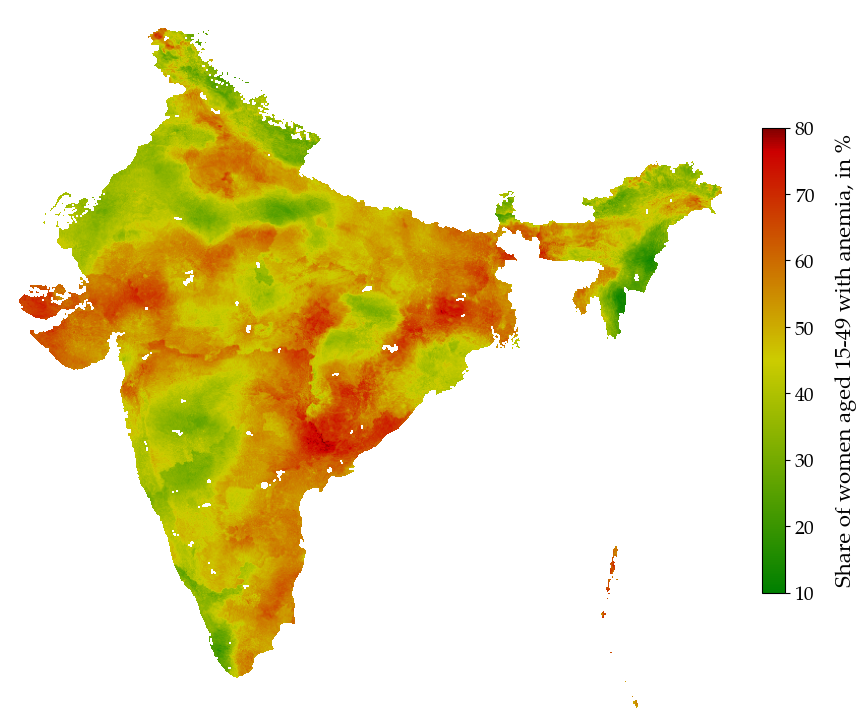

In [37]:


# Open the raster file
with rasterio.open(tiff_reprojected, 'r') as src2:
    # Access the raster data and metadata
    out_image2 = src2.read()
    out_meta2 = src2.meta.copy()
    target_crs = 'EPSG:4326'


# Set pixels with a value of zero to NaN (missing)
out_image[out_image <= 0.001] = np.nan


# Define a custom colormap with linear transitions
colors = [(0, 0.5, 0), (0.8, 0.8, 0), (0.8, 0, 0), (0.5,0,0)]  # forest green-dark yellow-red black
positions = [0, 0.5, 0.95, 1]  # corresponding positions for the colors
custom_cmap = LinearSegmentedColormap.from_list('custom', list(zip(positions, colors)), N=256)

colors2 = [(0, 0, 0, 0), (0, 0, 0.5, 0.3)]  # transparent-black and dark blue with 50% transparency
positions2 = [0, 1]  # corresponding positions for the colors
custom_cmap2 = LinearSegmentedColormap.from_list('custom', list(zip(positions2, colors2)), N=256)


# Normalize based on your pixel values (0 to 15 in this case)
norm = Normalize(vmin=10, vmax=80)

# Visualize the pixel values
fig, ax = plt.subplots(figsize=(10, 10))
image = ax.imshow(out_image[0], cmap=custom_cmap, norm=norm)
# image2 = ax.imshow(out_image2[0], cmap=custom_cmap2)


# Remove x and y axis
ax.set_axis_off()

# Title
title_font = {'fontname': 'Palatino Linotype', 'fontsize': 20, 'horizontalalignment': 'center'}
other_font = {'fontname': 'Palatino Linotype', 'fontsize': 16}



# Add a colorbar for reference
cbar = fig.colorbar(image, ax=ax,  fraction=0.03, pad=0.05)
cbar.set_label('Share of women aged 15-49 with anemia, in %',  labelpad=15, **other_font)


# Set font for colorbar ticks
for tick in cbar.ax.yaxis.get_ticklabels():
    tick.set_fontname('Palatino Linotype')
    tick.set_fontsize(14)

plt.savefig('../Output/Maps/Anemia_all_2019.png', dpi=300, transparent=True)
plt.show()


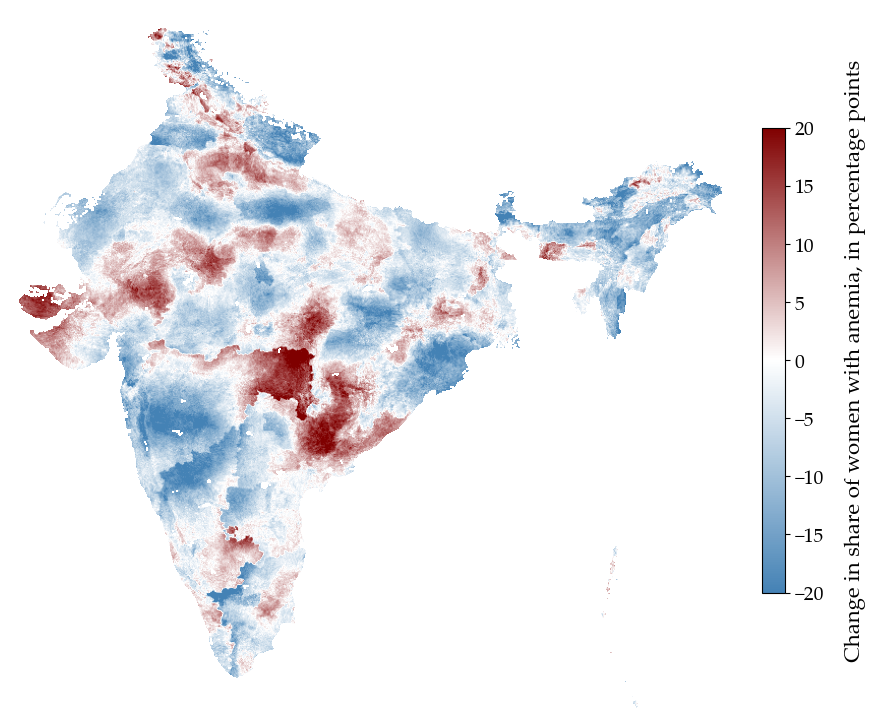

In [39]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
from rasterio.crs import CRS




## Difference in pixel values

# Load the first TIFF file
tif_file1 = '../Data/Global Anemia Prevalence Geospatial Estimates 2000-2019/3 - All Anemia [GeoTIFF]/Mean/IHME_GLOBAL_ANEMIA_2000_2019_ALL_ANEMIA_PREV_MEAN_2019_Y2020M08D31.TIF'
with rasterio.open(tif_file1) as src1:
    data1 = src1.read(1)
    src_crs = src1.crs


# Set pixels with a value of zero to NaN (missing)
data1[data1 <= 0.001] = np.nan

# Load the second TIFF file
tif_file2 = '../Data/Global Anemia Prevalence Geospatial Estimates 2000-2019/3 - All Anemia [GeoTIFF]/Mean/IHME_GLOBAL_ANEMIA_2000_2019_ALL_ANEMIA_PREV_MEAN_2000_Y2020M08D31.TIF'
with rasterio.open(tif_file2) as src2:
    data2 = src2.read(1)
data2[data2 <= 0.001] = np.nan

# Calculate the pixel-wise difference
difference = data1 - data2

# Save the difference array to a new raster file
output_difference_path = '../Output/Maps/anemia_diff.tiff'  # Specify the desired output path
with rasterio.open(output_difference_path, 'w', **src1.meta) as dst:
    dst.write(difference, 1)

# Open the saved difference raster file
with rasterio.open(output_difference_path) as src:
    # Clip raster with shapefile geometry
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()

out_image[out_image <= -100] = np.nan



boundary_shapefile = '../Maps_QGIS/gadm36_IND_shp/gadm36_IND_1.shp'
gdf_boundary = gpd.read_file(boundary_shapefile)
gdf_boundary = gdf_boundary.to_crs(epsg=4326)



# Define a custom colormap with linear transitions
colors = [(0.27, 0.51, 0.71), (1, 1, 1), (0.5, 0, 0)]  # steel blue-white-dark red/maroon
positions = [0, 0.5, 1]  # corresponding positions for the colors
custom_cmap = LinearSegmentedColormap.from_list('custom', list(zip(positions, colors)), N=256)

# Normalize based on your pixel values (0 to 15 in this case)
norm = Normalize(vmin=-20, vmax=20)

# Visualize the pixel values
fig, ax = plt.subplots(figsize=(10, 10))  # Set transparent to True

# gdf_boundary.plot(ax=ax, color='darkblue', alpha=0.5, linewidth=10)
# gdf.plot(ax=ax, facecolor='none', edgecolor='darkblue', linewidth=1)


# Plot the clipped map with pixel values using the custom colormap and normalization
image = ax.imshow(out_image[0], cmap=custom_cmap, norm=norm)


# Remove x and y axis
ax.set_axis_off()

# Title
title_font = {'fontname': 'Palatino Linotype', 'fontsize': 20, 'horizontalalignment': 'center'}
other_font = {'fontname': 'Palatino Linotype', 'fontsize': 16}

# ax.set_title(' Anemia, India, Change 2000 to 2019', **title_font,  x=0.6, pad=2)


# Add a colorbar for reference
cbar = fig.colorbar(image, ax=ax,  fraction=0.03, pad=0.05)
cbar.set_label('Change in share of women with anemia, in percentage points',  labelpad=15, **other_font)


# Set font for colorbar ticks
for tick in cbar.ax.yaxis.get_ticklabels():
    tick.set_fontname('Palatino Linotype')
    tick.set_fontsize(14)

# Save the figure with transparent background
plt.savefig('../Output/Maps/Anemia_all_2019-2000.png', transparent=True)


plt.show()

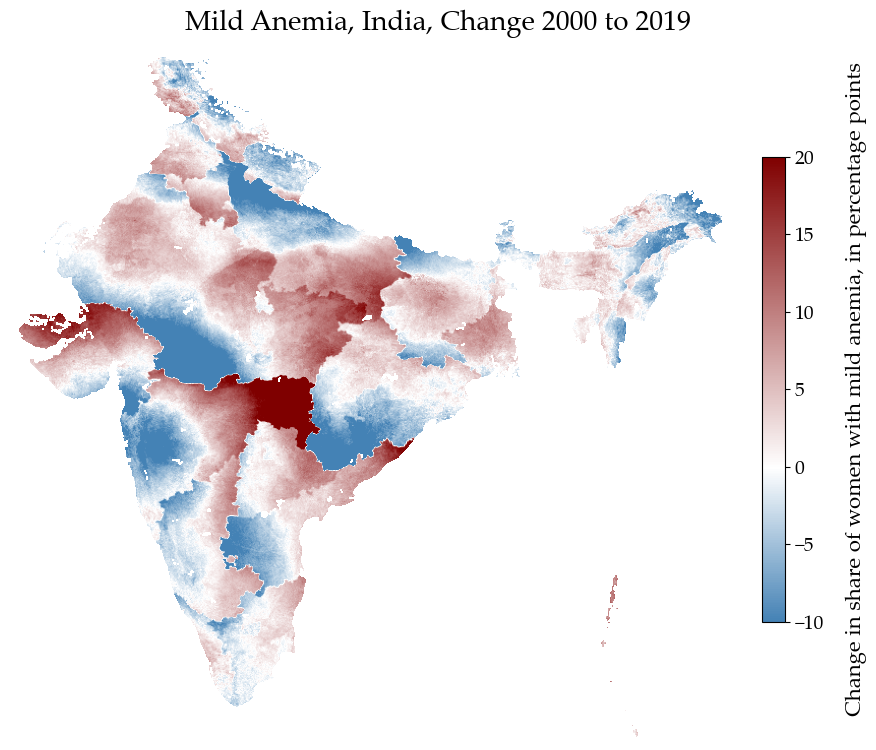

In [115]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
from rasterio.crs import CRS




## Difference in pixel values

# Load the first TIFF file
tif_file1 = '../Data/Global Anemia Prevalence Geospatial Estimates 2000-2019/4 - Mild Anemia [GeoTIFF]/Mean/IHME_GLOBAL_ANEMIA_2000_2019_MILD_ANEMIA_PREV_MEAN_2019_Y2020M08D31.TIF'
with rasterio.open(tif_file1) as src1:
    data1 = src1.read(1)
    src_crs = src1.crs


# Set pixels with a value of zero to NaN (missing)
data1[data1 <= 0.001] = np.nan

# Load the second TIFF file
tif_file2 = '../Data/Global Anemia Prevalence Geospatial Estimates 2000-2019/4 - Mild Anemia [GeoTIFF]/Mean/IHME_GLOBAL_ANEMIA_2000_2019_MILD_ANEMIA_PREV_MEAN_2000_Y2020M08D31.TIF'
with rasterio.open(tif_file2) as src2:
    data2 = src2.read(1)
data2[data2 <= 0.001] = np.nan

# Calculate the pixel-wise difference
difference = data1 - data2

# Save the difference array to a new raster file
output_difference_path = '../Output/Maps/anemia_diff.tiff'  # Specify the desired output path
with rasterio.open(output_difference_path, 'w', **src1.meta) as dst:
    dst.write(difference, 1)

# Open the saved difference raster file
with rasterio.open(output_difference_path) as src:
    # Clip raster with shapefile geometry
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()

out_image[out_image <= -100] = np.nan



boundary_shapefile = '../Maps_QGIS/gadm36_IND_shp/gadm36_IND_1.shp'
gdf_boundary = gpd.read_file(boundary_shapefile)
gdf_boundary = gdf_boundary.to_crs(epsg=4326)



# Define a custom colormap with linear transitions
colors = [(0.27, 0.51, 0.71), (1, 1, 1), (0.5, 0, 0)]  # steel blue-white-dark red/maroon
positions = [0, 0.33, 1]  # corresponding positions for the colors
custom_cmap = LinearSegmentedColormap.from_list('custom', list(zip(positions, colors)), N=256)

# Normalize based on your pixel values (0 to 15 in this case)
norm = Normalize(vmin=-10, vmax=20)

# Visualize the pixel values
fig, ax = plt.subplots(figsize=(10, 10))  # Set transparent to True

# gdf_boundary.plot(ax=ax, color='darkblue', alpha=0.5, linewidth=10)
# gdf.plot(ax=ax, facecolor='none', edgecolor='darkblue', linewidth=1)


# Plot the clipped map with pixel values using the custom colormap and normalization
image = ax.imshow(out_image[0], cmap=custom_cmap, norm=norm)


# Remove x and y axis
ax.set_axis_off()

# Title
title_font = {'fontname': 'Palatino Linotype', 'fontsize': 20, 'horizontalalignment': 'center'}
other_font = {'fontname': 'Palatino Linotype', 'fontsize': 16}

ax.set_title('Mild Anemia, India, Change 2000 to 2019', **title_font,  x=0.6, pad=2)


# Add a colorbar for reference
cbar = fig.colorbar(image, ax=ax,  fraction=0.03, pad=0.05)
cbar.set_label('Change in share of women with mild anemia, in percentage points',  labelpad=15, **other_font)


# Set font for colorbar ticks
for tick in cbar.ax.yaxis.get_ticklabels():
    tick.set_fontname('Palatino Linotype')
    tick.set_fontsize(14)

# Save the figure with transparent background
plt.savefig('../Output/Maps/Anemia_mild_2019-2000.png', transparent=True)


plt.show()

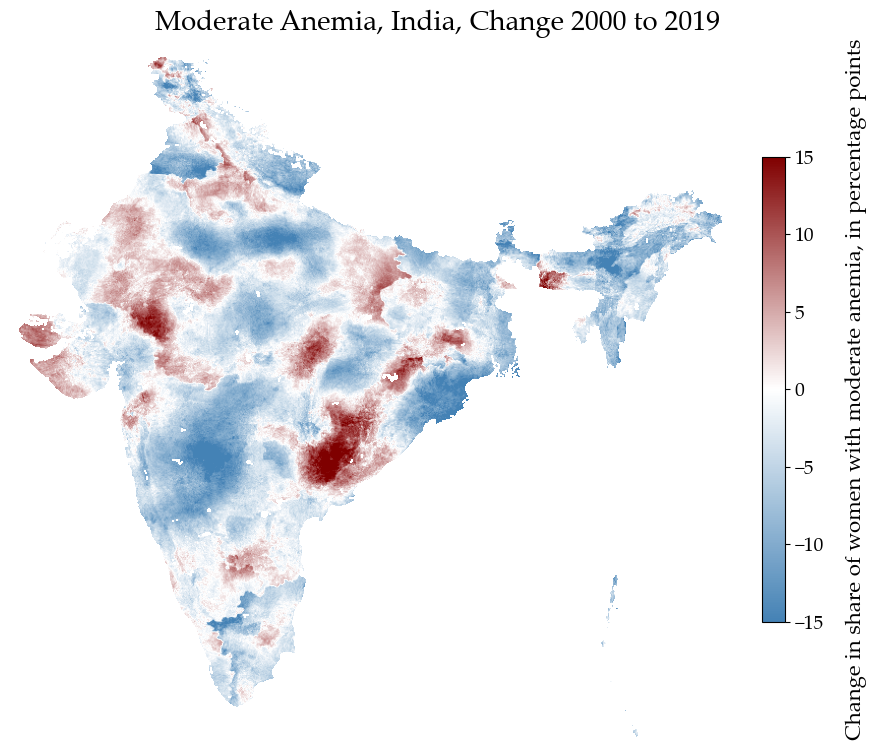

In [118]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
from rasterio.crs import CRS




## Difference in pixel values

# Load the first TIFF file
tif_file1 = '../Data/Global Anemia Prevalence Geospatial Estimates 2000-2019/5 - Moderate Anemia [GeoTIFF]/Mean/IHME_GLOBAL_ANEMIA_2000_2019_MOD_ANEMIA_PREV_MEAN_2019_Y2020M08D31.TIF'
with rasterio.open(tif_file1) as src1:
    data1 = src1.read(1)
    src_crs = src1.crs


# Set pixels with a value of zero to NaN (missing)
data1[data1 <= 0.001] = np.nan

# Load the second TIFF file
tif_file2 = '../Data/Global Anemia Prevalence Geospatial Estimates 2000-2019/5 - Moderate Anemia [GeoTIFF]/Mean/IHME_GLOBAL_ANEMIA_2000_2019_MOD_ANEMIA_PREV_MEAN_2000_Y2020M08D31.TIF'
with rasterio.open(tif_file2) as src2:
    data2 = src2.read(1)
data2[data2 <= 0.001] = np.nan

# Calculate the pixel-wise difference
difference = data1 - data2

# Save the difference array to a new raster file
output_difference_path = '../Output/Maps/anemia_diff.tiff'  # Specify the desired output path
with rasterio.open(output_difference_path, 'w', **src1.meta) as dst:
    dst.write(difference, 1)

# Open the saved difference raster file
with rasterio.open(output_difference_path) as src:
    # Clip raster with shapefile geometry
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()

out_image[out_image <= -100] = np.nan



boundary_shapefile = '../Maps_QGIS/gadm36_IND_shp/gadm36_IND_1.shp'
gdf_boundary = gpd.read_file(boundary_shapefile)
gdf_boundary = gdf_boundary.to_crs(epsg=4326)



# Define a custom colormap with linear transitions
colors = [(0.27, 0.51, 0.71), (1, 1, 1), (0.5, 0, 0)]  # steel blue-white-dark red/maroon
positions = [0, 0.5, 1]  # corresponding positions for the colors
custom_cmap = LinearSegmentedColormap.from_list('custom', list(zip(positions, colors)), N=256)

# Normalize based on your pixel values (0 to 15 in this case)
norm = Normalize(vmin=-15, vmax=15)

# Visualize the pixel values
fig, ax = plt.subplots(figsize=(10, 10))  # Set transparent to True

# gdf_boundary.plot(ax=ax, color='darkblue', alpha=0.5, linewidth=10)
# gdf.plot(ax=ax, facecolor='none', edgecolor='darkblue', linewidth=1)


# Plot the clipped map with pixel values using the custom colormap and normalization
image = ax.imshow(out_image[0], cmap=custom_cmap, norm=norm)


# Remove x and y axis
ax.set_axis_off()

# Title
title_font = {'fontname': 'Palatino Linotype', 'fontsize': 20, 'horizontalalignment': 'center'}
other_font = {'fontname': 'Palatino Linotype', 'fontsize': 16}

ax.set_title('Moderate Anemia, India, Change 2000 to 2019', **title_font,  x=0.6, pad=2)


# Add a colorbar for reference
cbar = fig.colorbar(image, ax=ax,  fraction=0.03, pad=0.05)
cbar.set_label('Change in share of women with moderate anemia, in percentage points',  labelpad=15, **other_font)


# Set font for colorbar ticks
for tick in cbar.ax.yaxis.get_ticklabels():
    tick.set_fontname('Palatino Linotype')
    tick.set_fontsize(14)

# Save the figure with transparent background
plt.savefig('../Output/Maps/Anemia_moderate_2019-2000.png', transparent=True)


plt.show()

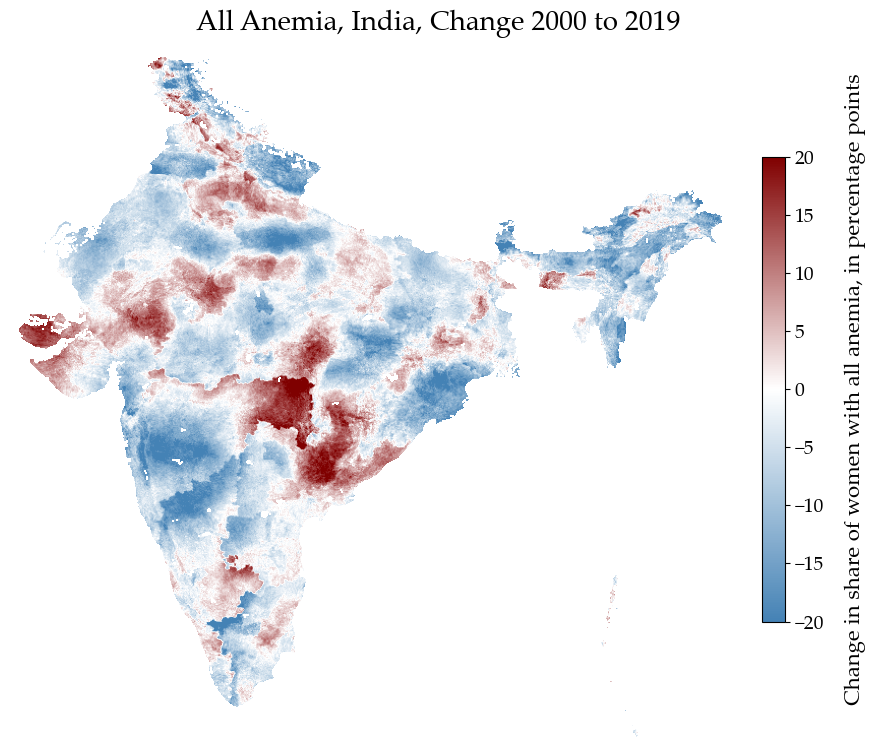

In [123]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
from rasterio.crs import CRS




## Difference in pixel values

# Load the first TIFF file
tif_file1 = '../Data/Global Anemia Prevalence Geospatial Estimates 2000-2019/3 - All Anemia [GeoTIFF]/Mean/IHME_GLOBAL_ANEMIA_2000_2019_ALL_ANEMIA_PREV_MEAN_2019_Y2020M08D31.TIF'
with rasterio.open(tif_file1) as src1:
    data1 = src1.read(1)
    src_crs = src1.crs


# Set pixels with a value of zero to NaN (missing)
data1[data1 <= 0.001] = np.nan

# Load the second TIFF file
tif_file2 = '../Data/Global Anemia Prevalence Geospatial Estimates 2000-2019/3 - All Anemia [GeoTIFF]/Mean/IHME_GLOBAL_ANEMIA_2000_2019_ALL_ANEMIA_PREV_MEAN_2000_Y2020M08D31.TIF'
with rasterio.open(tif_file2) as src2:
    data2 = src2.read(1)
data2[data2 <= 0.001] = np.nan

# Calculate the pixel-wise difference
difference = data1 - data2

# Save the difference array to a new raster file
output_difference_path = '../Output/Maps/anemia_diff.tiff'  # Specify the desired output path
with rasterio.open(output_difference_path, 'w', **src1.meta) as dst:
    dst.write(difference, 1)

# Open the saved difference raster file
with rasterio.open(output_difference_path) as src:
    # Clip raster with shapefile geometry
    out_image, out_transform = mask(src, gdf.geometry, crop=True)
    out_meta = src.meta.copy()

out_image[out_image <= -100] = np.nan



boundary_shapefile = '../Maps_QGIS/gadm36_IND_shp/gadm36_IND_1.shp'
gdf_boundary = gpd.read_file(boundary_shapefile)
gdf_boundary = gdf_boundary.to_crs(epsg=4326)



# Define a custom colormap with linear transitions
colors = [(0.27, 0.51, 0.71), (1, 1, 1), (0.5, 0, 0)]  # steel blue-white-dark red/maroon
positions = [0, 0.5, 1]  # corresponding positions for the colors
custom_cmap = LinearSegmentedColormap.from_list('custom', list(zip(positions, colors)), N=256)

# Normalize based on your pixel values (0 to 15 in this case)
norm = Normalize(vmin=-20, vmax=20)

# Visualize the pixel values
fig, ax = plt.subplots(figsize=(10, 10))  # Set transparent to True

# gdf_boundary.plot(ax=ax, color='darkblue', alpha=0.5, linewidth=10)
# gdf.plot(ax=ax, facecolor='none', edgecolor='darkblue', linewidth=1)


# Plot the clipped map with pixel values using the custom colormap and normalization
image = ax.imshow(out_image[0], cmap=custom_cmap, norm=norm)


# Remove x and y axis
ax.set_axis_off()

# Title
title_font = {'fontname': 'Palatino Linotype', 'fontsize': 20, 'horizontalalignment': 'center'}
other_font = {'fontname': 'Palatino Linotype', 'fontsize': 16}

ax.set_title('All Anemia, India, Change 2000 to 2019', **title_font,  x=0.6, pad=2)


# Add a colorbar for reference
cbar = fig.colorbar(image, ax=ax,  fraction=0.03, pad=0.05)
cbar.set_label('Change in share of women with all anemia, in percentage points',  labelpad=15, **other_font)


# Set font for colorbar ticks
for tick in cbar.ax.yaxis.get_ticklabels():
    tick.set_fontname('Palatino Linotype')
    tick.set_fontsize(14)

# Save the figure with transparent background
plt.savefig('../Output/Maps/Anemia_all_2019-2000.png', transparent=True)


plt.show()